### Unzipping files

In [ ]:
# importing the zipfile module
from zipfile import ZipFile

# loading the temp.zip and creating a zip object
with ZipFile("/content/drive/MyDrive/images_prepped_train.zip", 'r') as zObject:

	# Extracting all the members of the zip
	# into a specific location.
	zObject.extractall(
		path="/content/drive/MyDrive/images_prepped_train/")


FileNotFoundError: ignored

### connecting google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


### Importing libraries

In [ ]:
import numpy as np
import tensorflow as tf

In [ ]:
from tensorflow.keras.layers import Input, Conv2D ,MaxPooling2D , UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.losses import SparseCategoricalCrossentropy


In [ ]:
import tensorflow

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import cv2

### Segnet

In [ ]:
def segnet(num_classes, model_input_shape = (256,256,3) ):
  inputs = Input(shape = model_input_shape)

  #encoder
  enc1 = Conv2D(64, (3,3) , activation = 'relu' , padding = 'same')(inputs)
  pool1 = MaxPooling2D(2,2)(enc1)
  enc2 = Conv2D(128,(3,3) , activation = 'relu' , padding = 'same')(pool1)
  pool2 = MaxPooling2D((2,2))(enc2)
  enc3 = Conv2D(256, (3,3) , activation = 'relu' , padding = 'same')(pool2)
  pool3 = MaxPooling2D(2,2)(enc3)
  enc4 = Conv2D(512,(3,3) , activation = 'relu' , padding = 'same')(pool3)
  pool4 = MaxPooling2D((2,2))(enc4)
  #decoder
  dec1 = Conv2D(512,(3,3), activation = 'relu' , padding = 'same')(pool4)
  up1 = UpSampling2D((2,2))(dec1)
  dec2 = Conv2D(256,(3,3), activation ='relu',padding ='same')(up1)
  up2 = UpSampling2D((2,2))(dec2)
  dec3 = Conv2D(128,(3,3), activation ='relu',padding ='same')(up2)
  up3= UpSampling2D((2,2))(dec3)
  dec4 = Conv2D(64,(3,3), activation ='relu',padding ='same')(up3)
  up4 = UpSampling2D((2,2))(dec4)
  outputs = Conv2D(3,(3,3), activation = 'relu' ,padding ='same')(up4)

  model = Model (inputs , outputs )
  return model

### FCN

In [ ]:
def create_fcn( num_classes, input_shape=(256, 256, 3)):
    inputs = Input(shape=input_shape)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Decoder
    up4 = UpSampling2D(size=(4, 4))(pool3)  # Adjust the upsampling factor
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(up4)
    merge4 = Concatenate(axis=-1)([conv2, conv4])
    up5 = UpSampling2D(size=(2, 2))(merge4)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(up5)
    merge5 = Concatenate(axis=-1)([conv1, conv5])

    # Output layer (1 channel for binary segmentation)
    outputs = Conv2D(1, 1, activation='sigmoid')(merge5)

    model = Model(inputs=inputs, outputs=outputs)
    return model

### Train generator

In [ ]:
image_dir = r"/content/drive/MyDrive/images_prepped_train/"
mask_dir = r"/content/drive/MyDrive/annotations_prepped_train"

In [ ]:
data_gen_args = dict(featurewise_center=True)
image_datagen = ImageDataGenerator(**data_gen_args , rescale = 1./255)
mask_datagen = ImageDataGenerator(**data_gen_args , rescale = 1./255)

#providing same seed and keyword arguments to the fit and flow methods
seed = 1

# image_datagen.fit(images,seed = seed)
# mask_datagen.fit(mask,seed=seed)

image_generator = image_datagen.flow_from_directory(
    image_dir,
    class_mode = None,
    seed =seed,
)
mask_generator = mask_datagen.flow_from_directory(
    mask_dir,
    class_mode= None,
    seed = seed,

)
print(image_generator.next().shape)
print(mask_generator.next().shape)
train_generator = zip(image_generator , mask_generator)

Found 367 images belonging to 1 classes.
Found 367 images belonging to 1 classes.
(32, 256, 256, 3)
(32, 256, 256, 3)


### Model

In [ ]:
# Define the number of classes (assuming you have a multi-class segmentation task)
num_classes = 50
model_input_shape = (256,256, 3)
# Create the SegNet model
model = create_fcn(num_classes,model_input_shape)
# model.add()

In [ ]:
def masked_categorical_crossentropy(gt, pr):
    from keras.losses import categorical_crossentropy
    mask = 1 - gt[:, :, 0]
    return categorical_crossentropy(gt, pr) * mask

In [ ]:
from tensorflow.keras.optimizers.legacy import SGD
model.compile(optimizer= Adam(lr = 0.001) , loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
# model_checkpoint = ModelCheckpoint('segnet_best_model.h5',save_weights_only=True, monitor='val_loss', mode='min', verbose=1)

Exception ignored in: <function _xla_gc_callback at 0x79bc68d4add0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 98, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_68 (Conv2D)          (None, 256, 256, 64)         1792      ['input_9[0][0]']             
                                                                                                  
 max_pooling2d_30 (MaxPooli  (None, 128, 128, 64)         0         ['conv2d_68[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 conv2d_69 (Conv2D)          (None, 128, 128, 128)        73856     ['max_pooling2d_30[0][0]

### Training Model

In [ ]:
model_checkpoint = ModelCheckpoint('segnets_best_model.h5')
model.fit(
    train_generator,
     batch_size = 4,
    callbacks=[model_checkpoint],
    steps_per_epoch = 90,
    epochs = 2,
)
model.save("segnets_best_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/2
90/90 [==============================] - 89s 880ms/step - loss: 0.0867 - accuracy: 0.1686
Epoch 2/2


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


90/90 [==============================] - 68s 751ms/step - loss: 0.0625 - accuracy: 0.1684


### Results

1/1 [==============================] - 1s 515ms/step


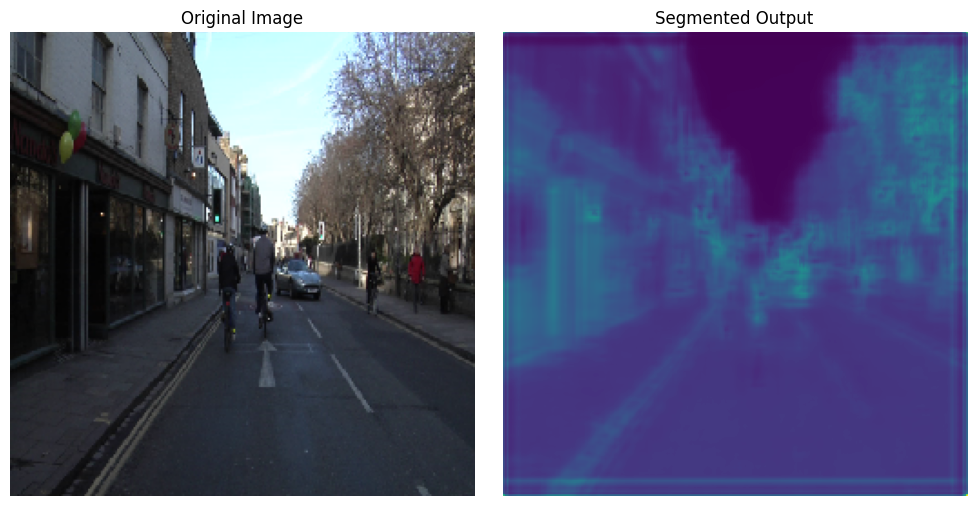

In [ ]:
# Define the path to the trained model
model_path = r'/content/segnets_best_model.h5'  # Replace with the path to your trained model

# Load the trained SegNet model
model = tf.keras.models.load_model(model_path)

# Define the path to the single test image
test_image_path =  r"testimage.png"  # Replace with the path to your test image


# img = cv2.imread('Image(347).png', cv2.IMREAD_UNCHANGED)
# img = cv2.resize(img,(256,256))
# Load and preprocess the test image
input_shape = (256,256,3) # Get the input shape from the model
test_image = load_img(test_image_path, target_size= input_shape)
test_image = img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)  # Add batch dimension
test_image = test_image / 255.0  # Normalize pixel values to [0, 1]

# Make predictions using the model
segmented_output = model.predict(test_image)

# Visualize the segmented output
plt.figure(figsize=(10, 5))

# Original test image
plt.subplot(1, 2, 1)
plt.imshow(test_image[0])
plt.title('Original Image')
plt.axis('off')

# Segmented output
plt.subplot(1, 2, 2)
plt.imshow(segmented_output[0, :, :, 0])  # Assuming binary segmentation
plt.title('Segmented Output')
plt.axis('off')

cv2.imwrite("segmented_output.png", segmented_output)
plt.tight_layout()
plt.show()
